In [294]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Make figures larger
plt.rcParams["figure.figsize"] = [16, 8]

print("pandas Version: " + pd.__version__)
print("numpy Version: " + np.__version__)
print("statsmodels Version: " + sm.__version__)

pandas Version: 1.2.4
numpy Version: 1.18.5
statsmodels Version: 0.12.2


In [295]:
df = pd.read_csv("../data/clean/trips_with_weather.csv", parse_dates=["date_from", "date_until"])
df.set_index("date_until", inplace=True)

In [344]:
df.head(3)

,bike_id,user_id,date_from,start_station_name,start_station_id,end_station_name,end_station_id,booked_via,duration_in_min,distance_in_km,speed_in_kmh,precip_intensity,precip_probability,precip_type,temperature,humidity,wind_speed,wind_bearing,uv_index,visibility
date_until,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:50:14,143517,A821059B555C7764A2FF801180874A2FCB326222,2014-01-01 00:34:54,U-Bahn Baumwall,214170,Mönckebergstraße / Rosenstraße,131880,iPhone SRH,16,1.293661,4.851229,0.0,0.0,none,1.93,0.81,3.91,161.0,0,9.988
2014-01-01 00:34:41,120450,2C6FD52D5611B4DAC29E5197B67979D583685948,2014-01-01 00:27:47,Lange Reihe / Lohmühlenpark,138385,Hauptbahnhof Ost / Hachmannplatz,131873,IVR,7,0.786254,6.739322,0.0,0.0,none,1.93,0.81,3.91,161.0,0,9.988
2014-01-01 00:56:32,117503,253528F56A582E05F13D8A89B20A23800DDEBEF2,2014-01-01 00:49:02,Sternschanze / Eingang Dänenweg,139501,Bahnhof Dammtor Süd / Marseiller Straße,138382,iPhone SRH,8,1.422850,10.671375,0.0,0.0,none,1.93,0.81,3.91,161.0,0,9.988


In [345]:
TRAIN_SIZE = 0.8
TEST_SIZE = 1.0 - TRAIN_SIZE

SAMPLE_START_DATE = "2016-05-01"
SAMPLE_END_DATE = "2016-05-31 23:59:59"

ADF_P_THRESHOLD = 0.05

In [346]:
sample_df = df[["end_station_id"]]
sample_df = sample_df.resample("H").count()
sample_df = sample_df.rename(columns={ "end_station_id": "check_ins" })
sample_df = sample_df[pd.Timestamp(SAMPLE_START_DATE):pd.Timestamp(SAMPLE_END_DATE)]
sample_df.head(3)

,check_ins
date_until,
2016-05-01 00:00:00,230
2016-05-01 01:00:00,244
2016-05-01 02:00:00,205


In [347]:
sample_df_station = df[["end_station_id"]][df.end_station_name == "U-Bahn Baumwall"]
sample_df_station = sample_df_station.resample("H").count()
sample_df_station = sample_df_station.rename(columns={ "end_station_id": "check_ins" })
sample_df_station = sample_df_station[pd.Timestamp(SAMPLE_START_DATE):pd.Timestamp(SAMPLE_END_DATE)]
sample_df_station.head(3)

,check_ins
date_until,
2016-05-01 00:00:00,2
2016-05-01 01:00:00,0
2016-05-01 02:00:00,1


In [348]:
def print_error_metrics(test_data, predicted_data):
    mape = mean_absolute_percentage_error(test_data.check_ins.values, predicted_data.predicted_mean.values)
    rmse = mean_squared_error(test_data.check_ins.values, predicted_data.predicted_mean.values)
    
    print("MAPE: %s" %(mape))
    print("RMSE: %s" %(rmse))

## Building a SARIMA model

### Plot data for first examination

<AxesSubplot:xlabel='date_until'>

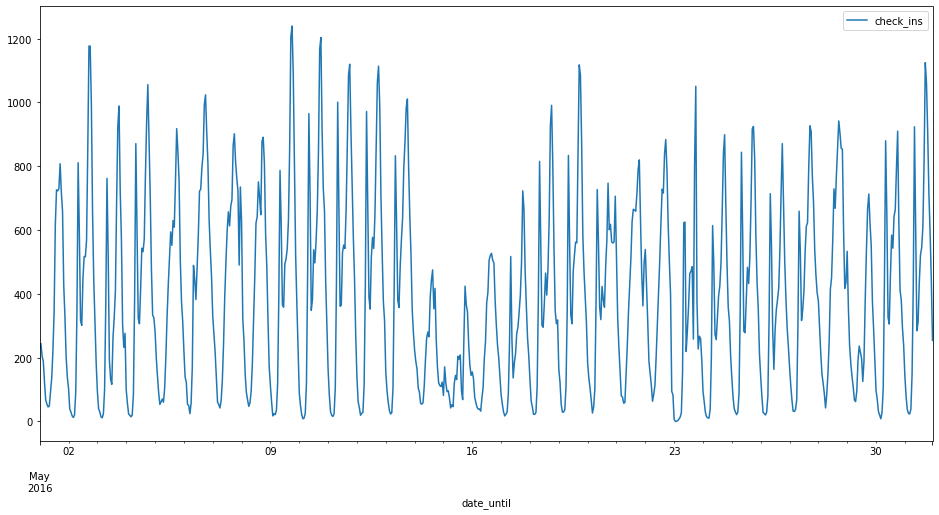

In [349]:
sample_df.plot()

### Check if the data is stationary with an ADF test

https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

Test stationarity with the *Augmented Dickey-Fuller* test for every data set. Data is stationary if the `p` value is lower than the threshold `ADF_P_THRESHOLD` and the test statistics value is negative and lower than the critical value for 1%.

In [350]:
def check_stationarity(input_df):
    adf_result = adfuller(input_df)
    stats = adf_result[0]
    p_value = adf_result[1]
    crit1 = adf_result[4]["1%"]
    stationary = (
        p_value < ADF_P_THRESHOLD
    ) and (
        (stats < 0) and (stats < crit1)
    )
    data = {
        "stats": [stats],
        "p_value": [p_value],
        "crit1": [crit1],
        "stationary": [stationary]
    }
    return pd.DataFrame(data)

In [351]:
check_stationarity(sample_df)

,stats,p_value,crit1,stationary
0,-4.006793,0.001375,-3.439427,True


The check-in data is stationary for all data sets and therefore does not require differenciation when predicting with an ARIMA model. Therefore the `d` parameter can be set to 0.

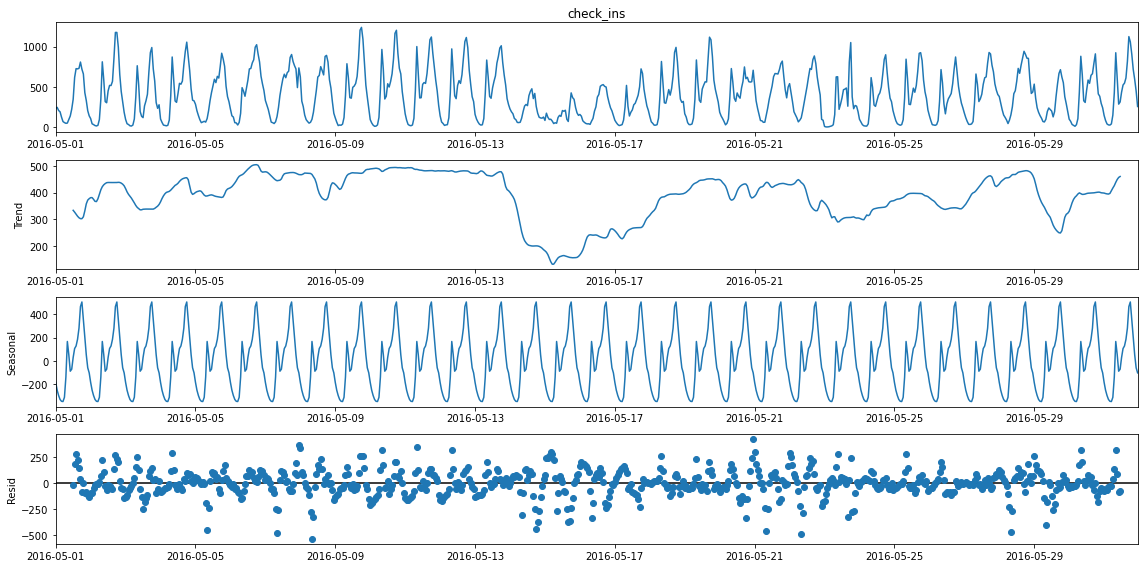

In [352]:
seasonal_decompose(sample_df.check_ins, period=24).plot()
plt.show()

### Check-in predictions for the next n hours overall

* Since data is seasonal, a SARIMA `(p,d,q)(P,D,Q)[S]` model will be used.
* Stationarity can be tested with the ADF method
* After applying differencing, if the ACF at lag 1 is -0.5 or more negative, the series may be overdifferenced

Rule of thumbs for parameters:

* `p` is equal to the first lag of the PACF plot that is still above the significance level, maybe one less
* `q` is equal to the first lag of the ACF plot that is still above the significance level, maybe one less
* `d` is 0 if the series has no visible trend or if the ACF at all lags is low

* `S` is equal to the ACF lag with the highest value / the amount of steps where a season is repeating
* `P` is >= 1 if the ACF is positive at lag `S`, else 0
* `D` is 1 if the seasonal pattern is stable over time, else 0
* `Q` is >= 1 if the ACF is negative at lag `S`, else 0

* `d`+`D` should be <= 2
* `P`+`Q` should be <= 2
* `p`+`d`+`q`+`P`+`D`+`Q` should be <= 6

In [353]:
train_data, test_data = train_test_split(
    sample_df, shuffle=False, train_size=TRAIN_SIZE, test_size=TEST_SIZE
)

# Resampling to set the frequency 'H' at the index again that is lost when using 'train_test_split'
# Prevents warning later on
train_data = train_data.resample("H").sum()
test_data = test_data.resample("H").sum()
print(len(sample_df))
print(len(train_data))
print(len(test_data))

744
595
149


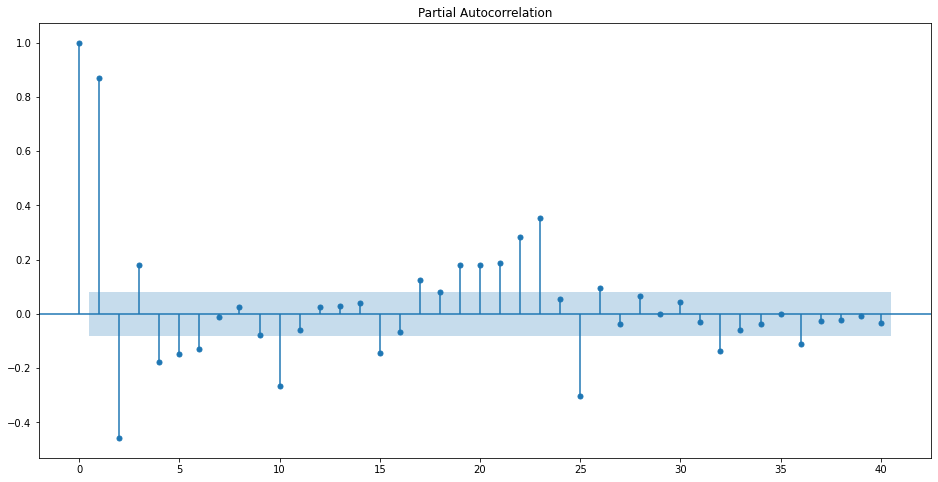

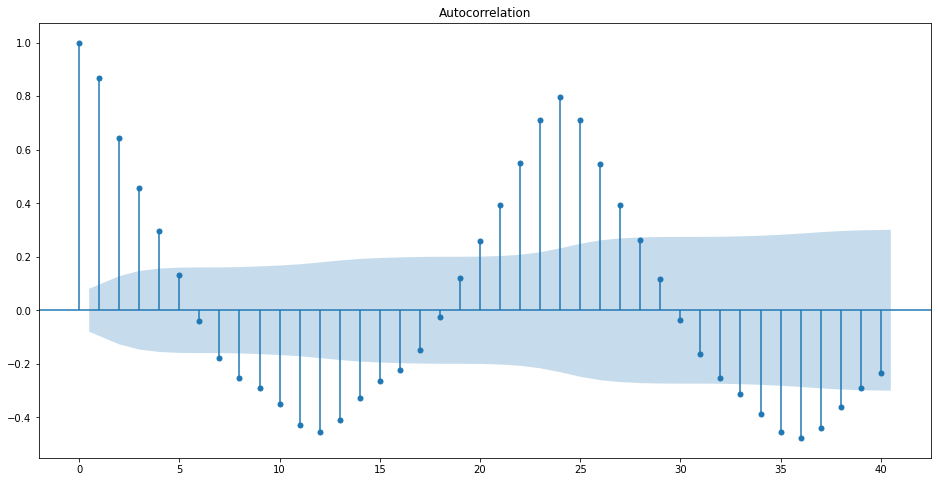

In [354]:
plot_pacf(train_data.check_ins, lags=40) # p
plt.show()

plot_acf(train_data.check_ins, lags=40) # q, S, P, Q
plt.show()

Following the rule of thumb, optimal parameters could be:

* `p = 1`
* `q = 3` or `q = 4`
* `S` is 24
* `P` is 1
* `Q` is 0

As data is stationary, `d` = 0.

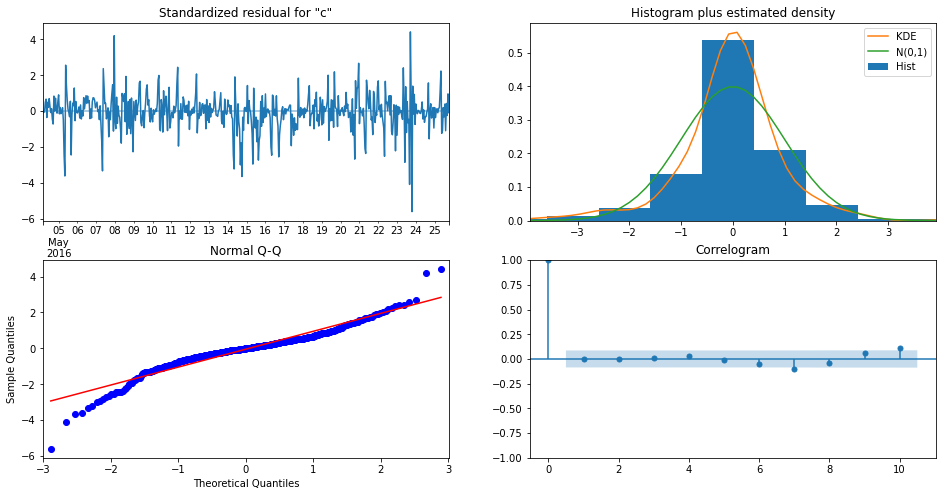

In [355]:
order = (1,0,3)
seasonal_order = (1,1,2,24)

sarima = SARIMAX(
    train_data,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_fit = sarima.fit()
sarima_fit.summary()

sarima_fit.plot_diagnostics()
plt.savefig("figures/sarima_diagnostics.png", bbox_inches="tight")
plt.show()

sarima_predictions = sarima_fit.predict(
    start=test_data.index.min(), end=test_data.index.max(), dynamic=True
).to_frame()

MAPE: 0.47548400028885174
RMSE: 17864.946691418914


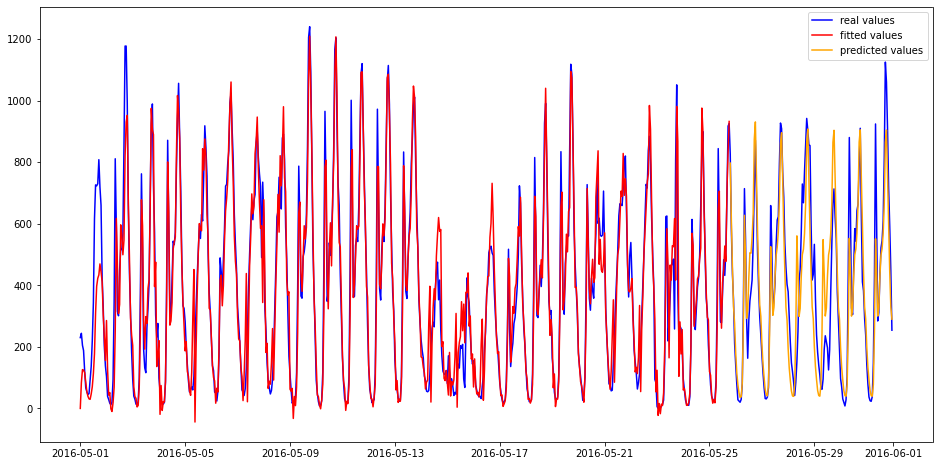

In [356]:
print_error_metrics(test_data, sarima_predictions)

test_steps = len(test_data)

plt.plot(sample_df, color="blue", label="real values")
plt.plot(sarima_fit.fittedvalues, color="red", label="fitted values")
plt.plot(sarima_predictions, color="orange", label="predicted values")
plt.legend()
plt.savefig("figures/sarima_predictions_%s_steps.png"%test_steps, bbox_inches="tight")
plt.show()

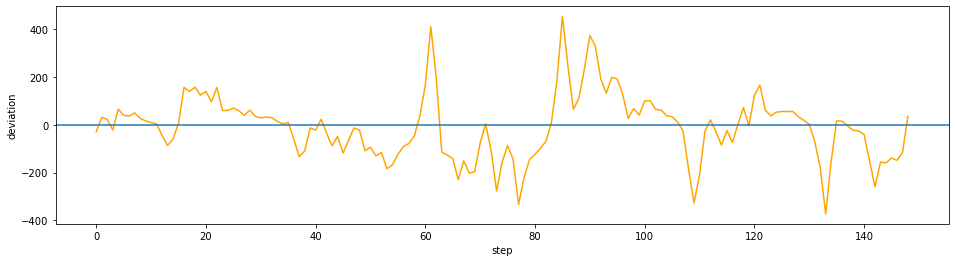

In [357]:
errors = sarima_predictions.predicted_mean.values - test_data.check_ins.values
plt.figure(figsize=(16,4))
plt.plot(errors, color="orange")
plt.axhline(0)
plt.xlabel("step")
plt.ylabel("deviation")
plt.savefig("figures/sarima_predictions_errors_%s_steps.png"%test_steps, bbox_inches="tight")
plt.show()

In [358]:
# MAPE
# 0.175343 (1,0,3) (1,1,1,24)
# 0.175593 (1,0,3) (1,1,2,24)

## Building a SARIMA model (station-level)

### Plot data for first examination

<AxesSubplot:xlabel='date_until'>

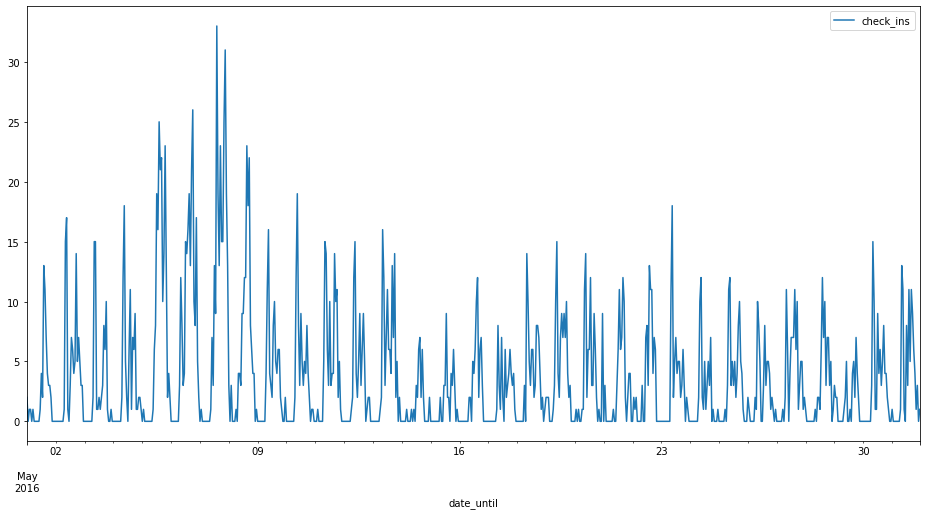

In [359]:
sample_df_station.plot()

### Check if the data is stationary with an ADF test

In [360]:
check_stationarity(sample_df_station)

,stats,p_value,crit1,stationary
0,-4.166897,0.000749,-3.439414,True


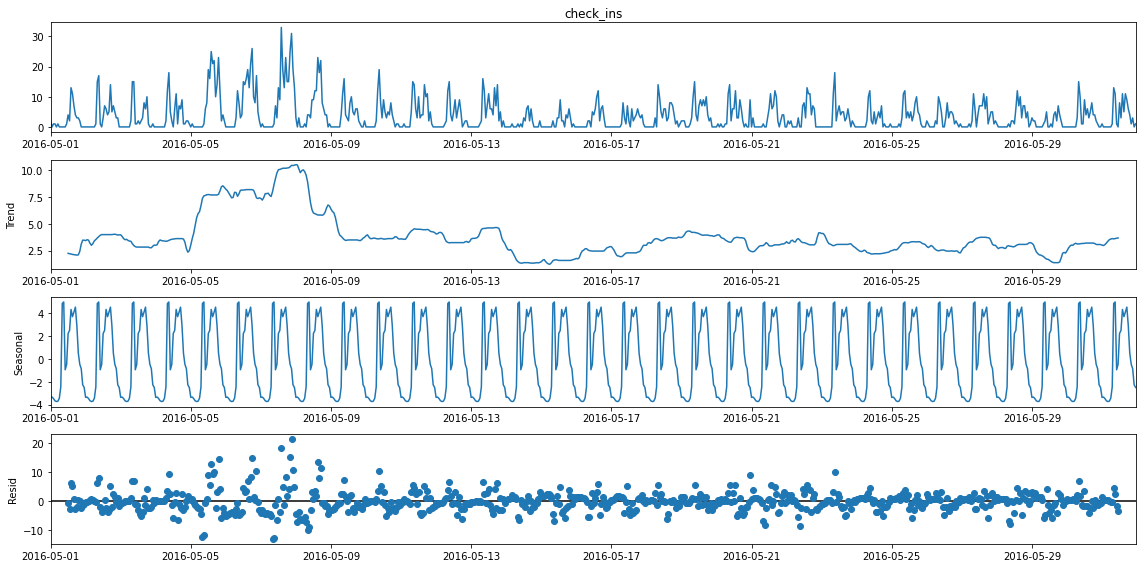

In [361]:
seasonal_decompose(sample_df_station.check_ins, period=24).plot()
plt.show()

### Check-in predictions for the next n hours overall

In [362]:
train_data_station, test_data_station = train_test_split(
    sample_df_station, shuffle=False, train_size=TRAIN_SIZE, test_size=TEST_SIZE
)

# Resampling to set the frequency 'H' at the index again that is lost when using 'train_test_split'
# Prevents warning later on
train_data_station = train_data_station.resample("H").sum()
test_data_station = test_data_station.resample("H").sum()

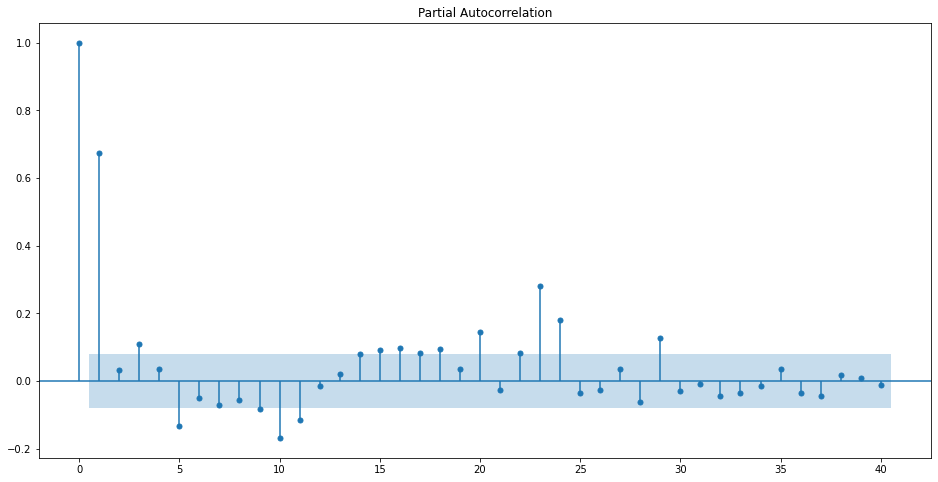

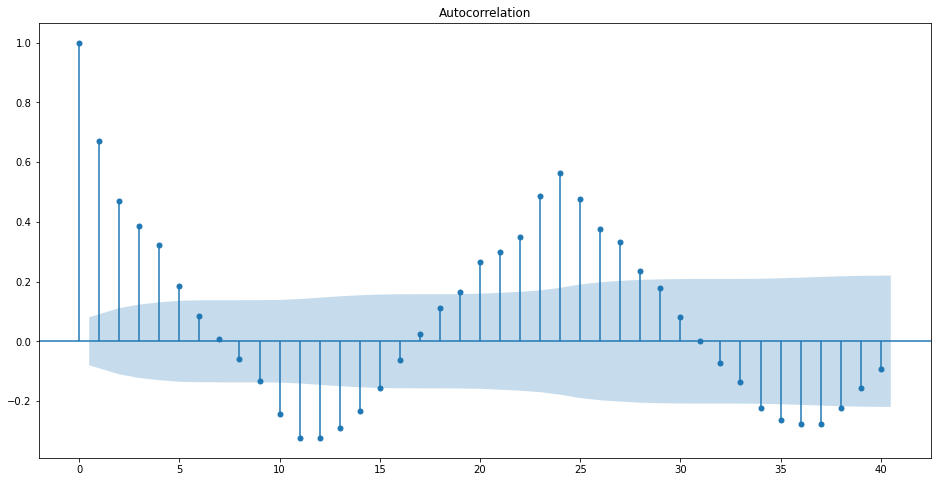

In [363]:
plot_pacf(train_data_station.check_ins, lags=40) # p
plt.show()

plot_acf(train_data_station.check_ins, lags=40) # q, S, P, Q
plt.show()

Following the rule of thumb, optimal parameters could be:

* `p = 1`
* `q = 3` or `q = 4`
* `S` is 24
* `P` is 1
* `Q` is 0

As data is stationary, `d` = 0.

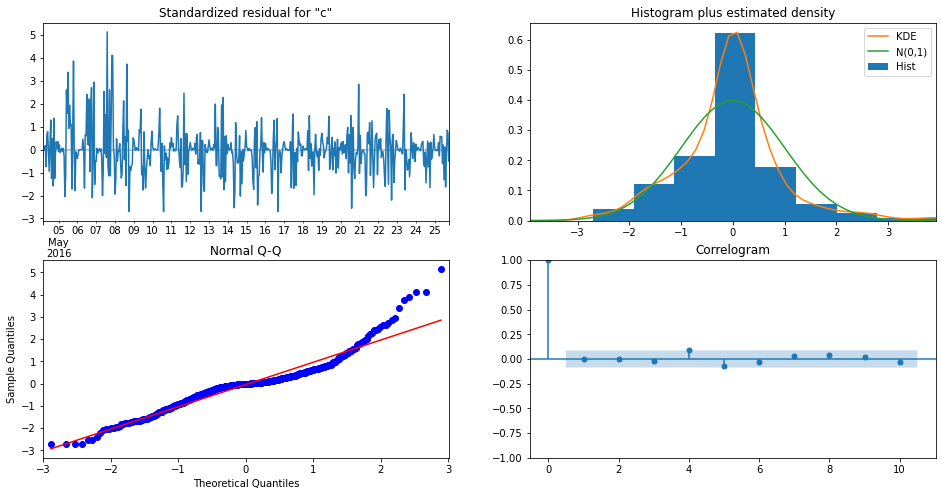

In [364]:
order_station = (1,0,3)
seasonal_order_station = (1,1,2,24)

sarima_station = SARIMAX(
    train_data_station,
    order=order_station,
    seasonal_order=seasonal_order_station,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_fit_station = sarima_station.fit()
sarima_fit_station.summary()

sarima_fit_station.plot_diagnostics()
plt.savefig("figures/sarima_diagnostics_station.png", bbox_inches="tight")
plt.show()

sarima_predictions_station = sarima_fit_station.predict(
    start=test_data_station.index.min(), end=test_data_station.index.max(), dynamic=True
).to_frame()

MAPE: 2223806230067125.2
RMSE: 7.4362410161766945


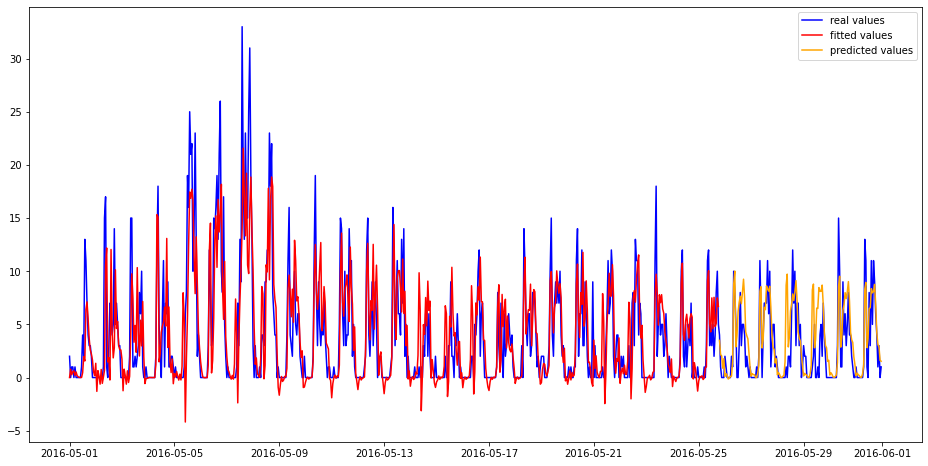

In [365]:
print_error_metrics(test_data_station, sarima_predictions_station)

plt.plot(sample_df_station, color="blue", label="real values")
plt.plot(sarima_fit_station.fittedvalues, color="red", label="fitted values")
plt.plot(sarima_predictions_station, color="orange", label="predicted values")
plt.legend()
plt.savefig("figures/sarima_predictions_station.png", bbox_inches="tight")
plt.show()

In [366]:
# MAPE
# 0.0977699 (1,0,3) (1,1,2,24)